In [1]:
%load_ext autoreload
%autoreload 2

from config.rnn import default
from models import RNN
import numpy as np
from functional import seq
import tensorflow as tf
from tensorpack import (TrainConfig, SyncMultiGPUTrainerParameterServer as Trainer, 
                        PredictConfig, MultiProcessDatasetPredictor as Predictor,
                        SaverRestore, logger)
from tensorpack.callbacks import (ScheduledHyperParamSetter, MaxSaver, ModelSaver,
                                  DataParallelInferenceRunner as InfRunner)
from tensorpack.predict import SimpleDatasetPredictor
from tensorpack.tfutils.common import get_default_sess_config
from utils import DataManager
from utils.validation import (Accumulator, AggerateMetric, calcu_metrics)

resnet_loc = "./data/resnet_v2_101/resnet_v2_101.ckpt"
logger.set_logger_dir('train_log', action='d')

[1020 15:18:17 @logger.py:74] Argv: /home/fuxiaofeng/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py -f /run/user/1012/jupyter/kernel-16809a9a-b230-422f-bdaa-1ca43bc784d3.json


In [2]:
config = default
config.stage = [2, 3, 4 ,5, 6]
config.annotation_number = 20
config.weight_decay = 5e-5
config.use_glimpse = True
config.read_time = 5

sess_config = get_default_sess_config(mem_fraction=0.3)
ignore_restore = ['learning_rate', 'global_step']
save_name = "rnn-5e-5-23456-dlv-max-auc.tfmodel"
threshold = 0.1

data_manager = DataManager(config)
print(data_manager.get_positive_ratio())
train_data = data_manager.get_train_stream()
val_data = data_manager.get_validation_stream()
test_data = data_manager.get_test_stream()
model = RNN(config)

Group numbers:
    train: 3992, validation: 1183, test: 1403
Image numbers:
    train: 7984, validation: 2366, test: 2806
                                     train       val      test
ubiquitous                        0.350451  0.374472  0.343550
faint ubiquitous                  0.207164  0.226543  0.207413
embryonic midgut                  0.181864  0.183432  0.179615
trunk mesoderm primordium         0.159068  0.169907  0.168924
posterior midgut primordium       0.139529  0.136940  0.138275
ventral nerve cord                0.131764  0.134404  0.133999
anterior midgut primordium        0.133517  0.133559  0.129722
embryonic brain                   0.127756  0.131868  0.129722
embryonic hindgut                 0.109719  0.109045  0.109765
embryonic dorsal epidermis        0.097194  0.096365  0.094084
brain primordium                  0.093186  0.093829  0.086244
embryonic/larval muscle system    0.090681  0.095520  0.093371
embryonic central nervous system  0.085922  0.087912  0.090

In [3]:
tf.reset_default_graph()
train_config = TrainConfig(model=model, dataflow=train_data,
                           callbacks=[
                               ScheduledHyperParamSetter('learning_rate', [(0, 5e-4), (20, 1e-4)]),
                               InfRunner(val_data, [AggerateMetric(config.validation_metrics, threshold)],
                                         [0, 1]),
                               ModelSaver(),
                               MaxSaver('macro-auc', save_name),
                           ],
                           session_init=SaverRestore(
                               model_path=resnet_loc, ignore=ignore_restore),
                           session_config=sess_config,
                           max_epoch=7, nr_tower=2)
Trainer(train_config).train()

[1020 15:18:21 @inference_runner.py:82] InferenceRunner will eval on an InputSource of size 18
[1020 15:18:22 @input_source.py:236] Setting up the queue 'QueueInput/input_queue' for CPU prefetching ...
[1020 15:18:22 @input_source.py:517] Setting up StagingArea for GPU prefetching ...
[1020 15:18:22 @training.py:69] Training a model of 2 towers
[1020 15:18:22 @training.py:120] Building graph for training tower 0 on device LeastLoadedDeviceSetter-/gpu:0...
INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.
[1020 15:18:27 @regularize.py:108] Add REGULARIZATION_LOSSES of 7 tensors on the total cost.
[1020 15:18:28 @training.py:120] Building graph for training tower 1 on device LeastLoadedDeviceSetter-/gpu:1...
INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.
[1020 15:18:30 @

[1020 15:18:42 @sessinit.py:119] Restoring checkpoint from ./data/resnet_v2_101/resnet_v2_101.ckpt ...
INFO:tensorflow:Restoring parameters from ./data/resnet_v2_101/resnet_v2_101.ckpt
[1020 15:18:43 @base.py:207] Graph Finalized.
[1020 15:18:43 @param.py:144] After epoch 0, learning_rate will change to 0.00050000
[1020 15:18:43 @concurrency.py:36] Starting EnqueueThread DataParallelInferenceRunner/QueueInput/input_queue ...
[1020 15:18:45 @concurrency.py:36] Starting EnqueueThread QueueInput/input_queue ...
[1020 15:18:45 @input_source.py:476] Pre-filling staging area ...
[1020 15:18:49 @base.py:241] Start Epoch 1 ...


100%|##########|62/62[02:24<00:00, 0.40it/s]

[1020 15:21:14 @base.py:251] Epoch 1 (global_step 62) finished, time:144.99 sec.



  0%|          |0/18[00:00<?,?it/s]/home/fuxiaofeng/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|##########|18/18[00:15<00:00, 1.20it/s]


[1020 15:21:30 @saver.py:90] Model saved to train_log/model-62.
[1020 15:21:30 @monitor.py:358] DataParallelInferenceRunner/QueueInput/queue_size: 50
[1020 15:21:30 @monitor.py:358] QueueInput/queue_size: 49.47
[1020 15:21:30 @monitor.py:358] coverage: 8.5712
[1020 15:21:30 @monitor.py:358] learning_rate: 0.0005
[1020 15:21:30 @monitor.py:358] loss/value: 0.20793
[1020 15:21:30 @monitor.py:358] macro_auc: 0.76483
[1020 15:21:30 @monitor.py:358] macro_f1: 0.071242
[1020 15:21:30 @monitor.py:358] mean_average_precision: 0.43507
[1020 15:21:30 @monitor.py:358] micro_auc: 0.64751
[1020 15:21:30 @monitor.py:358] micro_f1: 0.23754
[1020 15:21:30 @monitor.py:358] one_error: 0.58594
[1020 15:21:30 @monitor.py:358] rank_mean_average_precision: 0.43506
[1020 15:21:30 @monitor.py:358] ranking_loss: 0.31353
[1020 15:21:30 @group.py:42] Callbacks took 16.004 sec in total. DataParallelInferenceRunner: 15.289sec
[1020 15:21:30 @base.py:241] Start Epoch 2 ...


100%|##########|62/62[02:13<00:00, 0.46it/s]

[1020 15:23:43 @base.py:251] Epoch 2 (global_step 124) finished, time:133.19 sec.



100%|##########|18/18[00:15<00:00, 1.19it/s]


[1020 15:23:59 @saver.py:90] Model saved to train_log/model-124.
[1020 15:23:59 @monitor.py:358] DataParallelInferenceRunner/QueueInput/queue_size: 49.515
[1020 15:23:59 @monitor.py:358] QueueInput/queue_size: 49.776
[1020 15:23:59 @monitor.py:358] coverage: 6.3932
[1020 15:23:59 @monitor.py:358] learning_rate: 0.0005
[1020 15:23:59 @monitor.py:358] loss/value: 0.16642
[1020 15:23:59 @monitor.py:358] macro_auc: 0.90584
[1020 15:23:59 @monitor.py:358] macro_f1: 0.2588
[1020 15:23:59 @monitor.py:358] mean_average_precision: 0.66092
[1020 15:23:59 @monitor.py:358] micro_auc: 0.7863
[1020 15:23:59 @monitor.py:358] micro_f1: 0.40922
[1020 15:23:59 @monitor.py:358] one_error: 0.47569
[1020 15:23:59 @monitor.py:358] rank_mean_average_precision: 0.57827
[1020 15:23:59 @monitor.py:358] ranking_loss: 0.20156
[1020 15:23:59 @group.py:42] Callbacks took 15.541 sec in total. DataParallelInferenceRunner: 15.200sec
[1020 15:23:59 @base.py:241] Start Epoch 3 ...


100%|##########|62/62[02:12<00:00, 0.47it/s]

[1020 15:26:11 @base.py:251] Epoch 3 (global_step 186) finished, time:132.51 sec.



100%|##########|18/18[00:15<00:00, 1.18it/s]


[1020 15:26:27 @saver.py:90] Model saved to train_log/model-186.
[1020 15:26:27 @monitor.py:358] DataParallelInferenceRunner/QueueInput/queue_size: 49.549
[1020 15:26:27 @monitor.py:358] QueueInput/queue_size: 49.523
[1020 15:26:27 @monitor.py:358] coverage: 7.1458
[1020 15:26:27 @monitor.py:358] learning_rate: 0.0005
[1020 15:26:27 @monitor.py:358] loss/value: 0.14182
[1020 15:26:27 @monitor.py:358] macro_auc: 0.86081
[1020 15:26:27 @monitor.py:358] macro_f1: 0.251
[1020 15:26:27 @monitor.py:358] mean_average_precision: 0.56516
[1020 15:26:27 @monitor.py:358] micro_auc: 0.74989
[1020 15:26:27 @monitor.py:358] micro_f1: 0.347
[1020 15:26:27 @monitor.py:358] one_error: 0.79167
[1020 15:26:27 @monitor.py:358] rank_mean_average_precision: 0.41362
[1020 15:26:27 @monitor.py:358] ranking_loss: 0.25409
[1020 15:26:27 @group.py:42] Callbacks took 15.604 sec in total. DataParallelInferenceRunner: 15.280sec
[1020 15:26:27 @base.py:241] Start Epoch 4 ...


100%|##########|62/62[02:11<00:00, 0.47it/s]

[1020 15:28:38 @base.py:251] Epoch 4 (global_step 248) finished, time:131.39 sec.



100%|##########|18/18[00:15<00:00, 1.20it/s]


[1020 15:28:54 @saver.py:90] Model saved to train_log/model-248.
[1020 15:28:54 @monitor.py:358] DataParallelInferenceRunner/QueueInput/queue_size: 49.568
[1020 15:28:54 @monitor.py:358] QueueInput/queue_size: 49.517
[1020 15:28:54 @monitor.py:358] coverage: 7.3194
[1020 15:28:54 @monitor.py:358] learning_rate: 0.0005
[1020 15:28:54 @monitor.py:358] loss/value: 0.12315
[1020 15:28:54 @monitor.py:358] macro_auc: 0.88226
[1020 15:28:54 @monitor.py:358] macro_f1: 0.31026
[1020 15:28:54 @monitor.py:358] mean_average_precision: 0.61146
[1020 15:28:54 @monitor.py:358] micro_auc: 0.76104
[1020 15:28:54 @monitor.py:358] micro_f1: 0.34461
[1020 15:28:54 @monitor.py:358] one_error: 0.57639
[1020 15:28:54 @monitor.py:358] rank_mean_average_precision: 0.49547
[1020 15:28:54 @monitor.py:358] ranking_loss: 0.25577
[1020 15:28:54 @group.py:42] Callbacks took 15.558 sec in total. DataParallelInferenceRunner: 15.251sec
[1020 15:28:54 @base.py:241] Start Epoch 5 ...


100%|##########|62/62[02:11<00:00, 0.47it/s]

[1020 15:31:05 @base.py:251] Epoch 5 (global_step 310) finished, time:131.62 sec.



100%|##########|18/18[00:14<00:00, 1.21it/s]


[1020 15:31:21 @saver.py:90] Model saved to train_log/model-310.
[1020 15:31:21 @monitor.py:358] DataParallelInferenceRunner/QueueInput/queue_size: 49.58
[1020 15:31:21 @monitor.py:358] QueueInput/queue_size: 49.451
[1020 15:31:21 @monitor.py:358] coverage: 5.7804
[1020 15:31:21 @monitor.py:358] learning_rate: 0.0005
[1020 15:31:21 @monitor.py:358] loss/value: 0.11859
[1020 15:31:21 @monitor.py:358] macro_auc: 0.90186
[1020 15:31:21 @monitor.py:358] macro_f1: 0.45556
[1020 15:31:21 @monitor.py:358] mean_average_precision: 0.66014
[1020 15:31:21 @monitor.py:358] micro_auc: 0.84202
[1020 15:31:21 @monitor.py:358] micro_f1: 0.43928
[1020 15:31:21 @monitor.py:358] one_error: 0.47743
[1020 15:31:21 @monitor.py:358] rank_mean_average_precision: 0.59789
[1020 15:31:21 @monitor.py:358] ranking_loss: 0.17946
[1020 15:31:21 @group.py:42] Callbacks took 15.213 sec in total. DataParallelInferenceRunner: 14.914sec
[1020 15:31:21 @base.py:241] Start Epoch 6 ...


100%|##########|62/62[02:11<00:00, 0.47it/s]

[1020 15:33:32 @base.py:251] Epoch 6 (global_step 372) finished, time:131.33 sec.



100%|##########|18/18[00:14<00:00, 1.21it/s]


[1020 15:33:47 @saver.py:90] Model saved to train_log/model-372.
[1020 15:33:47 @monitor.py:358] DataParallelInferenceRunner/QueueInput/queue_size: 49.762
[1020 15:33:47 @monitor.py:358] QueueInput/queue_size: 49.477
[1020 15:33:47 @monitor.py:358] coverage: 3.8689
[1020 15:33:47 @monitor.py:358] learning_rate: 0.0005
[1020 15:33:47 @monitor.py:358] loss/value: 0.099784
[1020 15:33:47 @monitor.py:358] macro_auc: 0.93678
[1020 15:33:47 @monitor.py:358] macro_f1: 0.58278
[1020 15:33:47 @monitor.py:358] mean_average_precision: 0.72623
[1020 15:33:47 @monitor.py:358] micro_auc: 0.91396
[1020 15:33:47 @monitor.py:358] micro_f1: 0.59824
[1020 15:33:47 @monitor.py:358] one_error: 0.45139
[1020 15:33:47 @monitor.py:358] rank_mean_average_precision: 0.68067
[1020 15:33:47 @monitor.py:358] ranking_loss: 0.095658
[1020 15:33:47 @group.py:42] Callbacks took 15.284 sec in total. DataParallelInferenceRunner: 14.956sec
[1020 15:33:47 @base.py:241] Start Epoch 7 ...


100%|##########|62/62[02:11<00:00, 0.47it/s]

[1020 15:35:58 @base.py:251] Epoch 7 (global_step 434) finished, time:131.21 sec.



100%|##########|18/18[00:15<00:00, 1.19it/s]


[1020 15:36:14 @saver.py:90] Model saved to train_log/model-434.
[1020 15:36:14 @monitor.py:358] DataParallelInferenceRunner/QueueInput/queue_size: 49.679
[1020 15:36:14 @monitor.py:358] QueueInput/queue_size: 49.696
[1020 15:36:14 @monitor.py:358] coverage: 7.4332
[1020 15:36:14 @monitor.py:358] learning_rate: 0.0005
[1020 15:36:14 @monitor.py:358] loss/value: 0.091231
[1020 15:36:14 @monitor.py:358] macro_auc: 0.87138
[1020 15:36:14 @monitor.py:358] macro_f1: 0.35542
[1020 15:36:14 @monitor.py:358] mean_average_precision: 0.58474
[1020 15:36:14 @monitor.py:358] micro_auc: 0.76547
[1020 15:36:14 @monitor.py:358] micro_f1: 0.35342
[1020 15:36:14 @monitor.py:358] one_error: 0.74826
[1020 15:36:14 @monitor.py:358] rank_mean_average_precision: 0.4281
[1020 15:36:14 @monitor.py:358] ranking_loss: 0.25999
[1020 15:36:14 @group.py:42] Callbacks took 15.634 sec in total. DataParallelInferenceRunner: 15.295sec
[1020 15:36:14 @base.py:255] Training has finished!
[1020 15:36:14 @input_source.py:

In [30]:
#np.set_printoptions(formatter={'float_kind': lambda x: '%.3f' % x})
tf.reset_default_graph()
pred_config = PredictConfig(model=model,
                            session_init=SaverRestore(
                                model_path='train_log/' + save_name),
                            output_names=['logits_export', 'label'])
# pred = Predictor(pred_config, test_data, nr_proc=2, ordered=False)
pred = SimpleDatasetPredictor(pred_config, test_data)
accumulator = seq(pred.get_result()) \
    .smap(lambda a, b: calcu_metrics(a, b, config.validation_metrics, threshold)) \
    .aggregate(Accumulator(config.validation_metrics), lambda accu, dp: accu.feed(dp[1], *dp[0]))
metrics = accumulator.retrive()
print(metrics)

AssertionError: train_log/rnn-5e-5-23456-dlv-max-auc.tfmodel

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

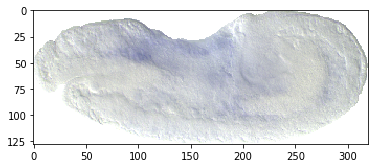

In [8]:
train_data.reset_state()
batch = next(train_data.get_data())
plt.imshow(batch[0][0][0])

In [7]:
img = batch[0][0][0]
img.dtype

dtype('uint8')

In [23]:
tf.get_collection(tf.GraphKeys.VARIABLES)

[<tf.Variable 'EMA/QueueInput/queue_size:0' shape=() dtype=float32_ref>,
 <tf.Variable 'EMA/QueueInput/queue_size/biased:0' shape=() dtype=float32_ref>,
 <tf.Variable 'EMA/QueueInput/queue_size/local_step:0' shape=() dtype=float32_ref>,
 <tf.Variable 'resnet_v2_101/conv1/weights:0' shape=(7, 7, 3, 64) dtype=float32_ref>,
 <tf.Variable 'resnet_v2_101/conv1/biases:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'resnet_v2_101/block1/unit_1/bottleneck_v2/preact/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'resnet_v2_101/block1/unit_1/bottleneck_v2/preact/gamma:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'resnet_v2_101/block1/unit_1/bottleneck_v2/preact/moving_mean:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'resnet_v2_101/block1/unit_1/bottleneck_v2/preact/moving_variance:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'resnet_v2_101/block1/unit_1/bottleneck_v2/shortcut/weights:0' shape=(1, 1, 64, 256) dtype=float32_ref>,
 <tf.Variable 'resnet_v2_101/block1/unit_1/bot